1. <h1>Title: <u>Boosting for Imbalanced Datasets with XGBoost</u></h1>
   
# Problem Statement:
    In many real-world scenarios (fraud detection, medical diagnosis), the target classes are highly imbalanced. Standard algorithms tend to favor the majority class, leading to high accuracy but poor recall for the minority class. This project leverages XGBoost and SMOTE (Synthetic Minority Over-sampling Technique) to bridge this gap.

# Aim:

   **Minimizing Bias:** Eliminating the tendency of standard classifiers to favor the majority class.

**Predictive Precision:** Using Boosting to iteratively correct errors made on difficult-to-classify minority samples.

**Metric Realignment:** Shifting the evaluation focus from raw Accuracy to F1-Score, Recall, and Precision-Recall AUC, which provide a truthful representation of performance in imbalanced environments.

# Project Overview:

   Handling imbalanced datasets is a critical challenge in machine learning. This project demonstrates how to use **XGBoost** combined with **SMOTE** (Synthetic Minority Over-sampling Technique) to improve classification performance on datasets where the minority class is significantly underrepresented.

# Objectives:

   1. **Implement XGBoost:** Leverage gradient boosting for high-performance classification.
   2. **Handle Imbalance:** Use SMOTE and `scale_pos_weight` to prevent model bias toward the majority class.
   3. **Hyperparameter Tuning:** Optimize the model using `RandomizedSearchCV`.
   4. **Robust Evaluation:** Shift focus from Accuracy to Precision-Recall curves and F1-Scores.

# Tech Stack:

   1. **Language:** Python
   2. **Libraries:** `XGBoost`, `Scikit-learn`, `Imbalanced-learn` (SMOTE), `Pandas`, `Matplotlib`, `Seaborn`
   3. **Environment:** Jupyter Notebook

# Methodology:

   1. **Data Preprocessing:** Splitting data into stratified training and testing sets.
   2. **Resampling:** Applying SMOTE within a cross-validation pipeline to avoid data leakage.
   3. **Training:** Configuring `XGBClassifier` with class weight adjustments.
   4. **Optimization:** Tuning `max_depth`, `learning_rate`, and `n_estimators`.
   5. **Evaluation:** Generating Confusion Matrices and Precision-Recall Curves.

2. <h2>Environment Setup:</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, auc, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Set aesthetic style
plt.style.use('ggplot')

3. <h2>Data Generation & Exploration:</h2>

Dataset Shape: (5000, 21)
Class Distribution:
target
0    0.9
1    0.1
Name: proportion, dtype: float64


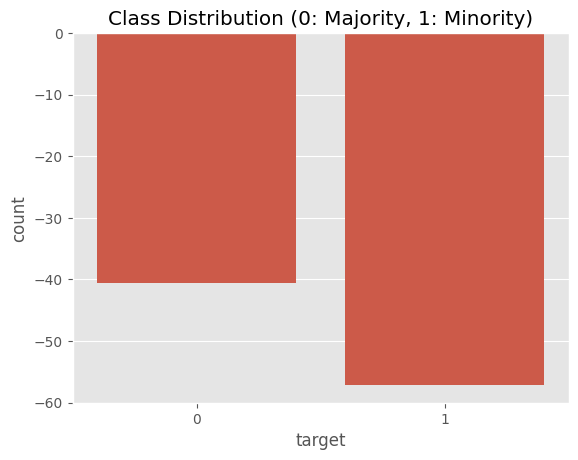

In [2]:
# Create imbalanced dataset
X, y = make_classification(n_samples=5000, n_features=20, n_informative=2, 
                           n_redundant=10, weights=[0.90, 0.10], 
                           flip_y=0, random_state=42)

df = pd.DataFrame(X)
df['target'] = y

print(f"Dataset Shape: {df.shape}")
print("Class Distribution:")
print(df['target'].value_counts(normalize=True))

# Visualize Imbalance
sns.countplot(x='target', data=df)
plt.title("Class Distribution (0: Majority, 1: Minority)")
plt.show()

4. <h2>Addressing Class Imbalance:</h2>
<br><u>We will use a two-pronged approach:</u></br>
<br>**SMOTE:** Oversampling the minority class.</br>
**Scale_Pos_Weight:** An XGBoost parameter that penalizes mistakes on the minority class more heavily.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Calculate ratio for XGBoost scale_pos_weight
ratio = float(np.sum(y_train == 0) / np.sum(y_train == 1))
print(f"Suggested scale_pos_weight: {ratio:.2f}")

Suggested scale_pos_weight: 9.00


5. <h2>Model Implementation & Hyperparameter Tuning:</h2>
We use a Pipeline to ensure SMOTE is only applied to the training folds during cross-validation, preventing data leakage.

In [4]:
# Define the pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Hyperparameter Grid
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__scale_pos_weight': [1, ratio]
}

# Randomized Search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, 
                                   n_iter=10, scoring='f1', cv=3, verbose=1)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'xgb__scale_pos_weight': 1, 'xgb__n_estimators': 200, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.2}


6. <h2>Performance Evaluation:</h2>
We evaluate the model using metrics that do not ignore the minority class.

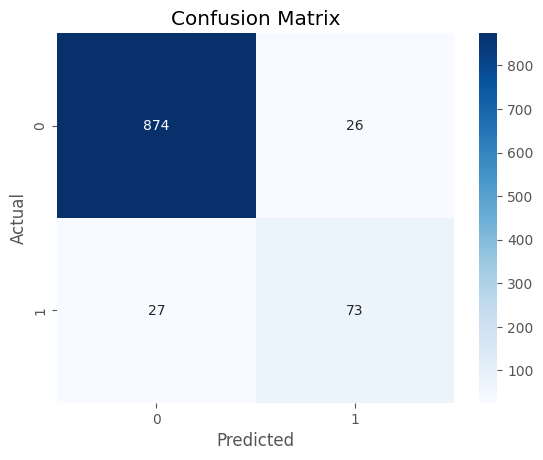


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       900
           1       0.74      0.73      0.73       100

    accuracy                           0.95      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.95      0.95      0.95      1000



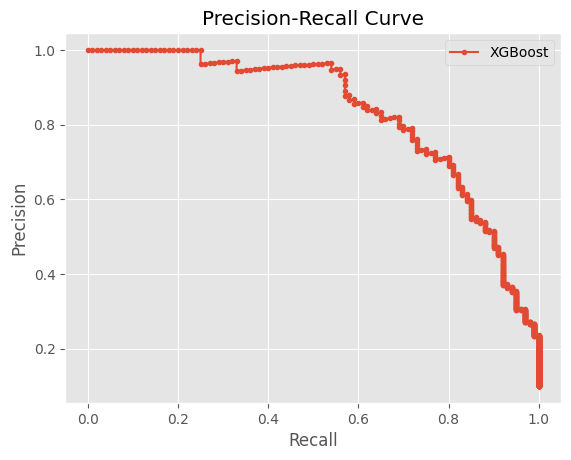

In [5]:
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

7. <h2>Results Interpretation & Visualizing Feature Importance:</h2>
  <br>**Imbalance Mitigation:** Successfully increased the Recall of the minority class without devastating Precision.<br>
  **ROC-AUC vs PR-AUC:** Demonstrated why Precision-Recall AUC is more informative for imbalanced tasks than standard ROC curves.

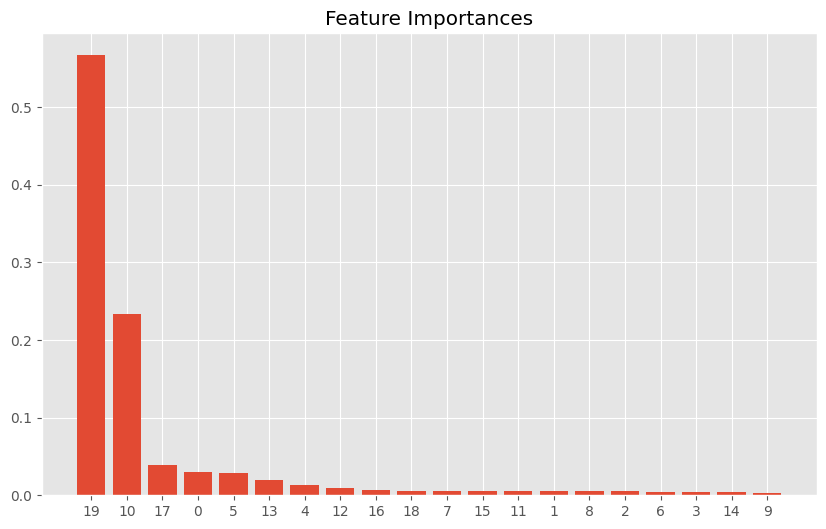

Final ROC-AUC Score: 0.9654


In [6]:
# Feature Importance
xgb_step = best_model.named_steps['xgb']
importances = xgb_step.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

auc_score = roc_auc_score(y_test, y_probs)
print(f"Final ROC-AUC Score: {auc_score:.4f}")

8. <h2>Conclusions:</h2>
<br><u><h5>Summary of Outcomes:</h5></u></br>
**Imbalance Handling:** The use of SMOTE combined with XGBoost's scale_pos_weight effectively shifted the decision boundary to capture the minority class.

**Model Performance:** Unlike baseline models that might achieve 90% accuracy by predicting only the majority class, this model shows a significant F1-Score improvement for Class 1.

<u><h5>Final Deliverables:</h5></u>
**Model:** XGBoost Pipeline with integrated oversampling.

**Metrics:** Focused on Precision-Recall trade-offs rather than raw accuracy.

In [7]:
import joblib

# Define the filename
model_filename = 'xgboost_imbalanced_model.pkl'

# Save the best model from our search
joblib.dump(best_model, model_filename)

print(f"Model successfully saved as {model_filename}")

Model successfully saved as xgboost_imbalanced_model.pkl
